In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : n_WyE-2w 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 543678.62
  Predicted background counts     : 533641.14
  Predicted excess counts         : 10037.49

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2297944.15

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

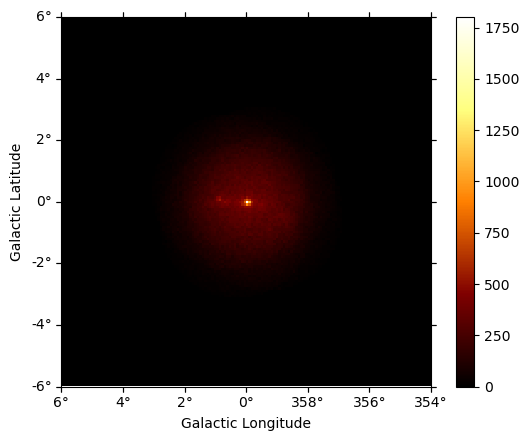

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].frozen = True
dataset_standard.models[0].parameters['lat_0'].frozen = True
dataset_standard.models[1].parameters['lon_0'].frozen = True
dataset_standard.models[1].parameters['lat_0'].frozen = True
#dataset_standard.models[2].parameters['lon_0'].frozen = True
#dataset_standard.models[2].parameters['lat_0'].frozen = True
#dataset_standard.models[3].parameters['lon_0'].frozen = True
#dataset_standard.models[3].parameters['lat_0'].frozen = True
#dataset_standard.models[4].parameters['lon_0'].frozen = True
#dataset_standard.models[4].parameters['lat_0'].frozen = True

#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (21, 21, 24)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64



<WCSAxesSubplot: >

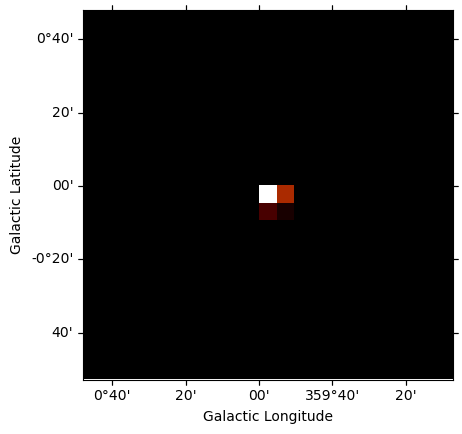

In [4]:
flux = dataset_standard.evaluators['Source'].compute_flux()
print(flux)
flux.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (21, 21, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

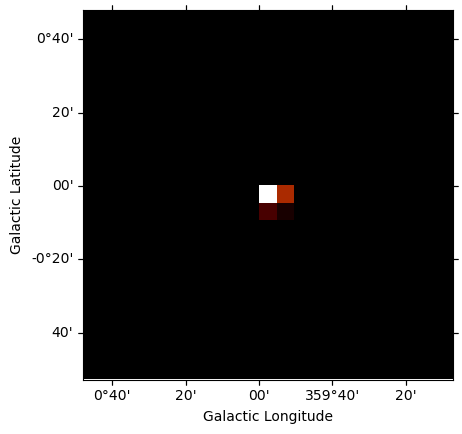

In [5]:
npred = dataset_standard.evaluators['Source'].apply_exposure(flux)
print(npred)
npred.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (21, 21, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

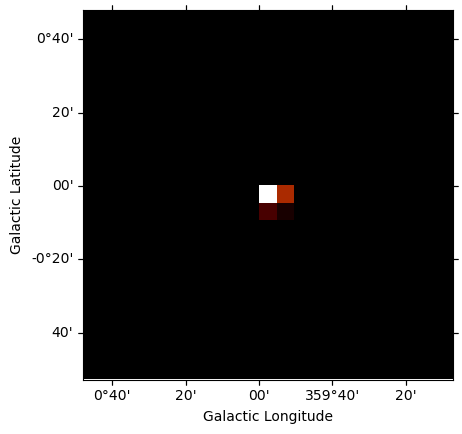

In [6]:
npred_reco = dataset_standard.evaluators['Source'].apply_edisp(npred)
print(npred_reco)
npred_reco.slice_by_idx(dict(energy = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (21, 21, 24)
	ndim  : 3
	unit  : 
	dtype : float32



<WCSAxesSubplot: >

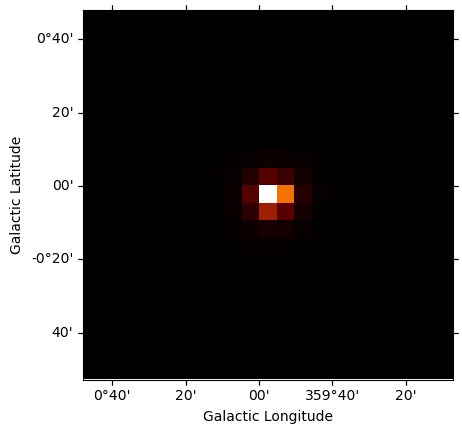

In [7]:
npred_reco_con = dataset_standard.evaluators['Source'].apply_psf(npred_reco)
print(npred_reco_con)
npred_reco_con.slice_by_idx(dict(energy = slice(10,11))).plot()

## Varying the Exposure

In [8]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.1 #-0.085
shift_pos = 0.1 #0.085
shift_cor = 0.0 #0.0

tilt_neg = -0.015#-0.015
tilt_pos = 0.015#-0.015
tilt_cor = 0.0

In [9]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [10]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor = sys_d_cor.create_dataset()
dataset_cor.mask_fit = mask_space

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg = sys_d_neg.create_dataset()
dataset_neg.mask_fit = mask_space

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos = sys_d_pos.create_dataset()
dataset_pos.mask_fit = mask_space

datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print(dataset_neg)

MapDataset
----------

  Name                            : A_sHentk 

  Total counts                    : 543678 
  Total background counts         : 533641.19
  Total excess counts             : 10037.44

  Predicted counts                : 542671.56
  Predicted background counts     : 533641.14
  Predicted excess counts         : 9030.43

  Exposure min                    : 4.96e+01 m2 s
  Exposure max                    : 1.46e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1989060.89

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramete

In [11]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure

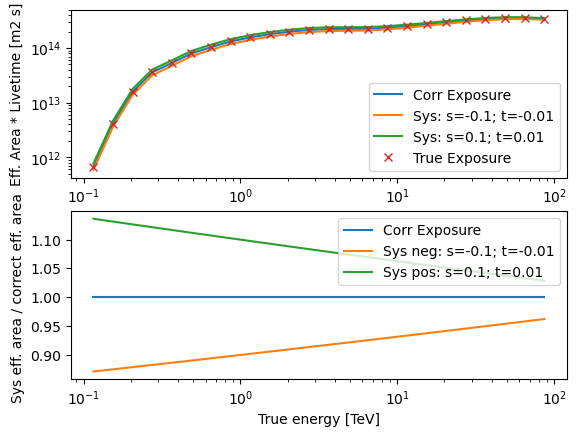

In [12]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.1}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

C:\Users\yt02izug\AppData\Local\Temp\ipykernel_9472\1851291678.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = "Model ")
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_9472\1851291678.py:27: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_9472\1851291678.py:29: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,


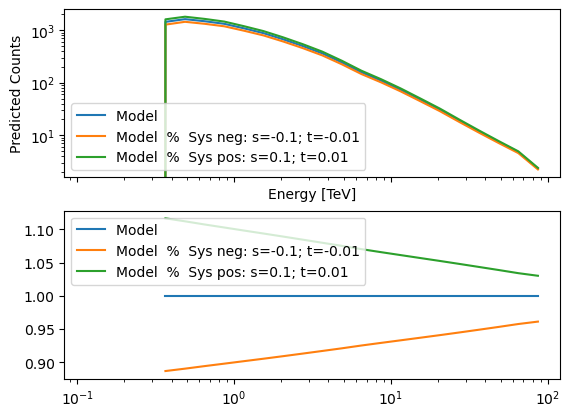

In [13]:
fig,ax = plt.subplots(2,1, sharex = True)

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)
#npred =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
#npred_neg = dataset_neg.npred_background().data.sum(axis = 2).sum(axis= 1)
#npred_pos = dataset_pos.npred_background().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model ")
ax[0].plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[0].plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

         
ax[0].loglog()
ax[0].legend()
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")


ax[1].plot(true_energy, npred/npred, label = "Model ")
ax[1].plot(true_energy, npred_neg/npred, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[1].plot(true_energy, npred_pos/npred,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

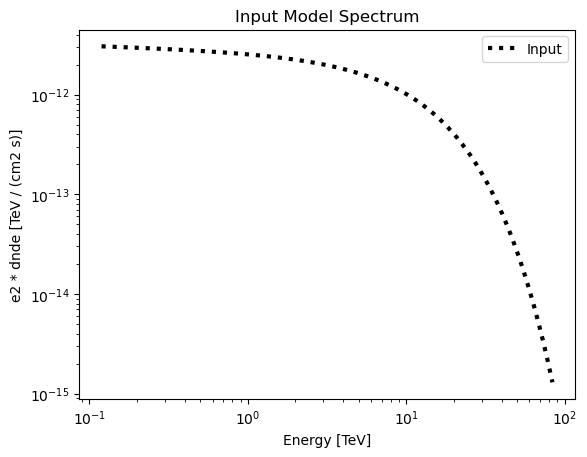

In [14]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


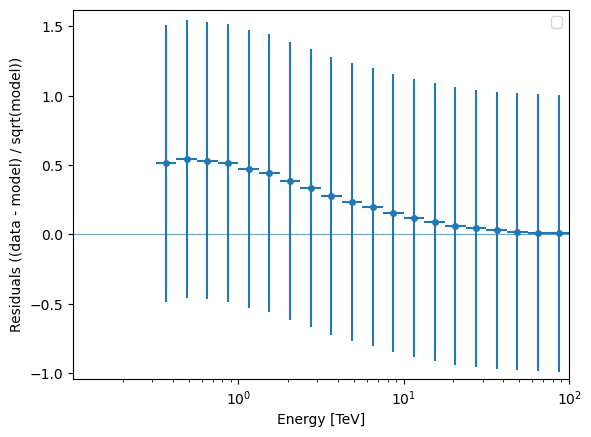

In [15]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

datasets_short[i].plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= colors[i])
#datasets_short[1].plot_residuals_spectral(ax =ax, color= colors[1])
#datasets_short[2].plot_residuals_spectral(ax =ax, color= colors[2])
ax.legend()
#fig.savefig(f"plots/1_Residual_bias={bias}sigma={sigma}."+figformat)


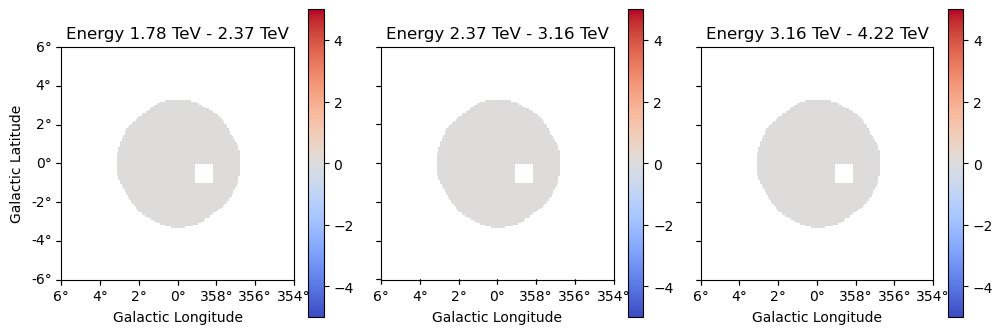

In [16]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

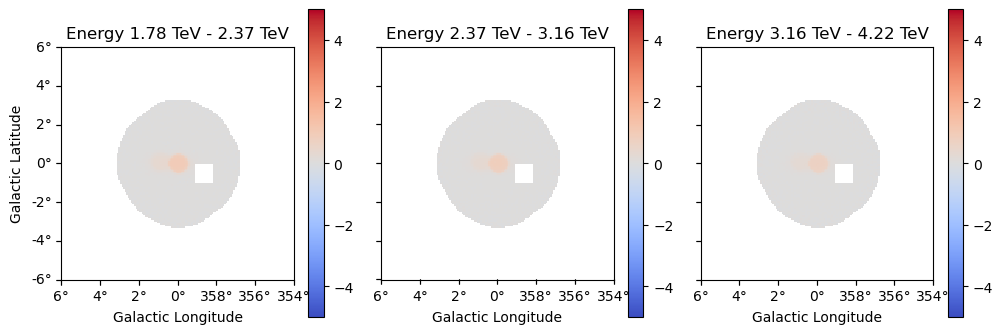

In [17]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

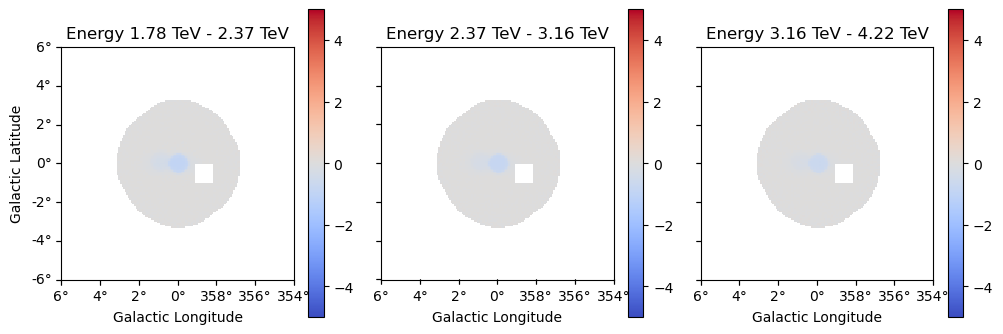

In [18]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [19]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_cor])

fit_neg = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run([dataset_neg])

fit_pos = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run([dataset_pos])
print(result_cor)
#print(result_pos)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 261
	total stat : -1989098.04

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: total: 54.6 s
Wall time: 54.6 s


In [20]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("Best Fit Amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit Bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
print("Best Fit Lambda")
lambdas = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas.append((value, error))
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/1_lambdas.yaml', 'w') as file:
    documents = yaml.dump(lambdas, file)
    
model_temp = Models(dataset_neg.models).copy()
model_temp.remove('diff')
model_temp.write("data/1_model_neg.yml", overwrite= True)
model_temp = Models(dataset_pos.models).copy()
model_temp.remove('diff')
model_temp.write("data/1_model_pos.yml", overwrite= True)
model_temp = Models(dataset_cor.models).copy()
model_temp.remove('diff')
model_temp.write("data/1_model_cor.yml", overwrite= True)

Best Fit amplitude
====
Input
2.76866354551871e-12 pm 8.228793349384577e-14
====
3.0805587921529883e-12 pm 9.11264618098168e-14
2.768659026421068e-12 pm 8.737788769459375e-14
2.5161799269092393e-12 pm 7.432709632202556e-14

Best Fit Index
====
Input
2.050614979527273 pm 0.0387962097995439
====
2.065906603364019 pm 0.03818439683402513
2.0506162030604265 pm 0.04312493222103259
2.0342971172386015 pm 0.03814003378864837

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.000018230597445 pm 0.0015570858214092145
0.9999999389891774 pm 0.0015574888167268876
0.9999845594464665 pm 0.0015576889064155763

Best Fit Lambda
====
Input
0.08880201229840431 pm 0.013538299688447261
====
0.089331224539148 pm 0.014158900766222457
0.08880142474983775 pm 0.016042153494450883
0.08882659136009814 pm 0.014081219737378109


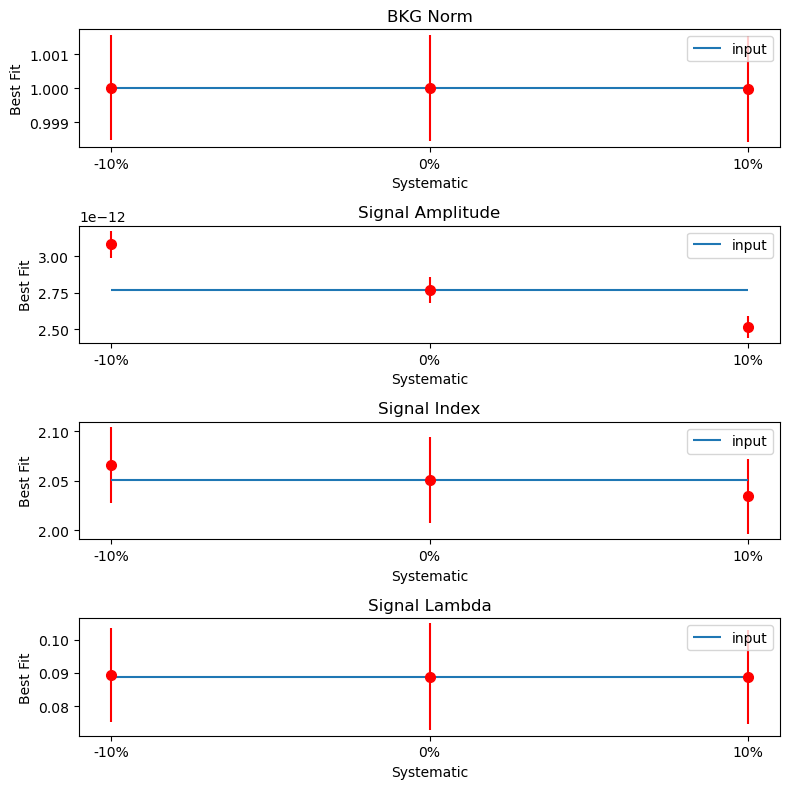

In [21]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels = ['-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[3].hlines( lambdas[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


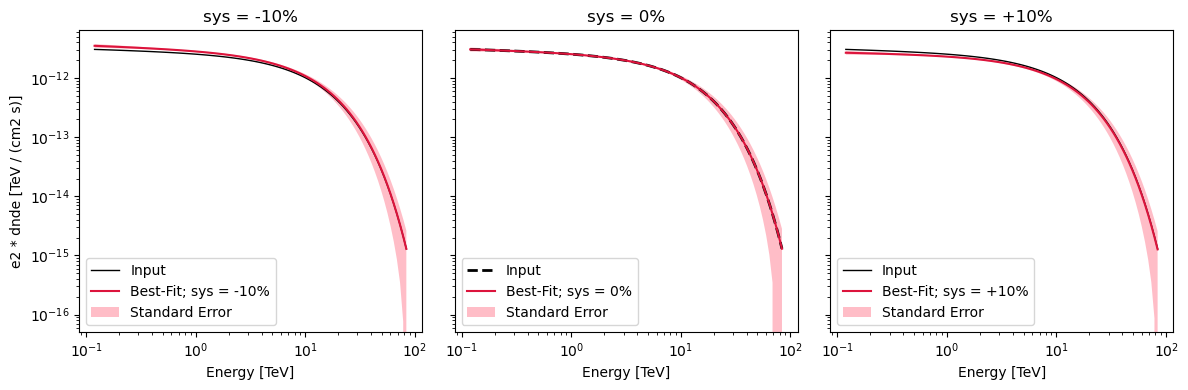

In [22]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

In [23]:
print(dataset_cor)

MapDataset
----------

  Name                            : TPd-Z_5I 

  Total counts                    : 543678 
  Total background counts         : 533641.19
  Total excess counts             : 10037.44

  Predicted counts                : 543678.60
  Predicted background counts     : 533641.11
  Predicted excess counts         : 10037.49

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1989098.04

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramet

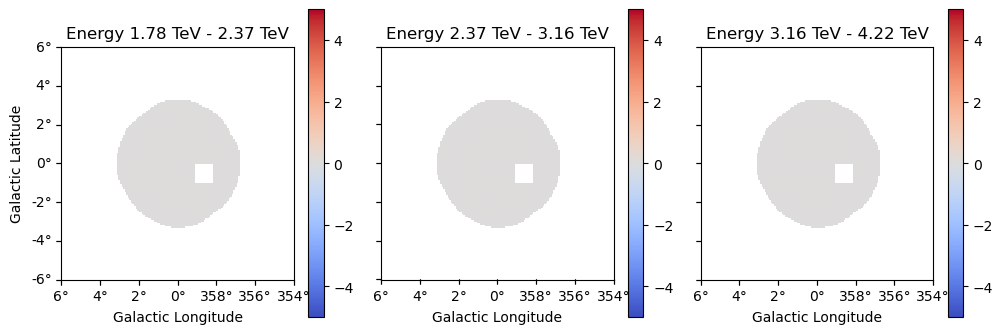

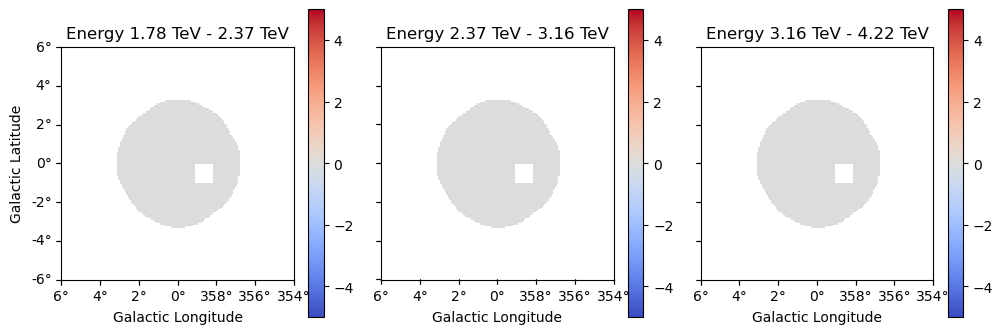

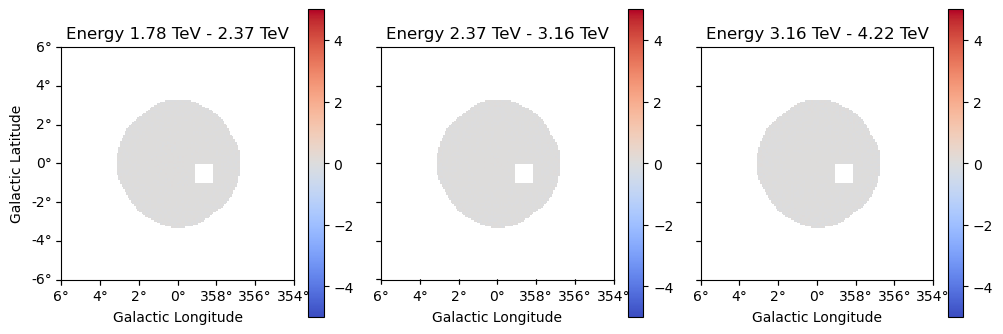

In [24]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);